# *n2i*: analysis

### TOC:
* [Demo](#Demo)
* [Analysis](#Analysis)
* [Grid search](#Grid search)

## Demo

n2i can be used both in command line and Jupyter notebook. The following code runs n2i with the default parameters.

NB: REMEBER TO DEFINE IF THE GRAPH IS DIRECTED AND/OR WEIGHTED

In [1]:
%matplotlib inline

In [2]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import networkx as nx
from scipy.spatial import distance
from n2i.__main__ import n2i_main

In [3]:
n2i_main(graph='../data/graph/lesmiserables/lesmiserables_edgelist.txt', reduce=False)

## Analysis

In [4]:
def read_graph(weighted, graph, directed):
    '''
    Reads the input network in networkx.
    '''
    #print(graph)
    if weighted:
        G = nx.read_edgelist(graph, nodetype=int, data=(('weight',float),), create_using=nx.DiGraph())
    else:
        G = nx.read_edgelist(graph, nodetype=int, create_using=nx.DiGraph())
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = 1

    if not directed:
        G = G.to_undirected()

    return G

In [5]:
def read_emb(emb, G):
    '''
    Returns embeddings from a given file
    '''
    file_name = pathlib.Path(emb)
    with open(file_name, 'r') as f:
        for line in f.readlines():
            line = line.replace(',','').replace('[','').replace(']','').split()
            node = int(line[0])
            emb = line[1:]
            G.nodes[node]['interests'] = [float(i) for i in emb]
            #print(emb)
    return G

In [6]:
# similarity between connected nodes
def sim_in(G):
    sims = []
    for i in G.nodes:
        for j in list(G.neighbors(i)):
            sims.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims)

def select_notedge(G):
    n = nx.number_of_nodes(G)
    while True:
        a, b = np.random.randint(0, n, size=2)
        if (a, b) not in G.edges:
            return a, b

# similarity between disconnected nodes
def sim_out(G, samples):
    sims_out = []
    for c in range(samples):
        i, j = select_notedge(G)
        sims_out.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims_out)

def homophily(G):
    return sim_in(G) - sim_out(G, 5000)

In [7]:
'''
G = read_graph(weighted=False, 
               graph='../WoMG/data/graph/lesmiserables/lesmiserables_edgelist.txt',
               directed=False)
G = read_emb('./emb2.txt', G=G)
'''

"\nG = read_graph(weighted=False, \n               graph='../WoMG/data/graph/lesmiserables/lesmiserables_edgelist.txt',\n               directed=False)\nG = read_emb('./emb2.txt', G=G)\n"

In [8]:
#si = sim_in(G)
#so = sim_out(G, 5000)
#print ("In similarity: {:.4f} \nOut similarity: {:.4f} \nHomophily rate: {:.4f}".format(si, so, si/so))

## Grid search

In [9]:
def grid_search(graph,
                topics=[15],
                dimensions=[128],
                walk_length=[80],
                num_walks=[10],
                window_size=[10],
                iiter=[1],
                p_val=[1],
                q_val=[1],
                out='./',
                reduce=True):

    for t in topics:
        for d in dimensions:
            for wk in walk_length:
                for n in num_walks:
                    for wi in window_size:
                        for ii in iiter:
                            for p in p_val:
                                for q in q_val:
                                    n2i_main(graph=graph, topics=t, 
                                             dimensions=d, walk_length=wk,
                                             num_walks=n, window_size=wi,
                                             iiter=ii, p=p, q=q,
                                             output=out,
                                             reduce=reduce)

In [10]:
graph = '../data/graph/lesmiserables/lesmiserables_edgelist.txt'
output_path = './Output2'
p_val = [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 4, 8]
q_val = [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 4, 8]

grid_search(graph=graph, p_val=p_val, q_val=q_val, out=output_path, reduce=False)

In [11]:
def read_files(path):
    '''
    Returns file names list in path
    '''
    files = next(pathlib.os.walk(str(path)))[2]
    for file in files:
        if file.startswith('.'):
            files.remove(file)
    return files

In [12]:
def make_stat(graph_path, emb_folder_path):
    '''
    Returns list with all the homophily ratio for each embeddings file
    '''
    G = read_graph(weighted=False, graph=graph_path, directed=False)
    stat = []
    files = read_files(emb_folder_path)
    for file in files:
        file_name = pathlib.Path(emb_folder_path) / file
        G_emb = read_emb(file_name, G)
        si = sim_in(G_emb)
        so = sim_out(G_emb, 5000)
        stat.append(si/so)
    return stat

In [13]:
graph_path = graph
emb_folder_path = output_path

stat = make_stat(graph_path=graph_path, emb_folder_path=emb_folder_path)

In [14]:
def make_df(stat_vec):
    '''
    Returns dataframe for p values (rows) and q valus (columns) with homophily values
    '''
    d = {str(q): [] for q in q_val}
    num_cols = len(q_val)
    num_rows = len(p_val)
    
    for r in range(num_rows):
        for c in range(num_cols):
            d[str(q_val[c])].append(stat_vec[c + r*num_cols])
    return pd.DataFrame(data=d, index=p_val)

In [15]:
df = make_df(stat)

Text(79,0.5,'p')

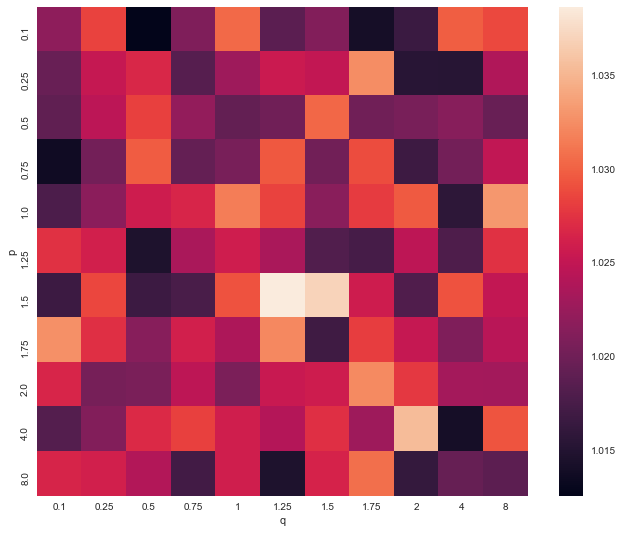

In [16]:
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(ax=ax, data=df)
plt.xlabel('q')
plt.ylabel('p')